In [1]:
!pip install cleanlab matplotlib
!pip install -q transformers datasets
!pip install unicode_tr
!pip install sadedegel
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unicode_tr: filename=unicode_tr-0.6.1-py3-none-any.whl size=2083 sha256=daf40a13c8f6e68af621eac60

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

from unicode_tr import unicode_tr

from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re

from cleanlab.filter import find_label_issues
import cleanlab.internal.multilabel_utils as mlutils
from cleanlab.internal.multilabel_utils import onehot2int, int2onehot

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

from collections import Counter

import optuna

import numpy as np

from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as de

In [6]:
intent = load_dataset("deprem-private/deprem_intent_classification", "intent_multilabel")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset deprem_intent_classification downloaded and prepared to /root/.cache/huggingface/datasets/deprem-private___deprem_intent_classification/intent_multilabel/1.2.0/c87d8f0c6bdb896fbf32b6d0cb53dded2e116b5427d01e75b681e54c67c745ea. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
intent["train"], intent["test"], intent["validation"]

(Dataset({
     features: ['labels', 'text_cleaned', 'text', 'tweet_id'],
     num_rows: 5555
 }), Dataset({
     features: ['labels', 'text_cleaned', 'text', 'tweet_id'],
     num_rows: 1544
 }), Dataset({
     features: ['labels', 'text_cleaned', 'text', 'tweet_id'],
     num_rows: 618
 }))

In [8]:
df_train = pd.DataFrame().from_records(list(intent["train"]))
df_test = pd.DataFrame().from_records(list(intent["test"]))
df_valid = pd.DataFrame().from_records(list(intent["validation"]))

In [9]:
df_train = pd.concat([df_train, df_valid]).reset_index(drop=True)

In [10]:
label_col = "labels"
text_col = "text_cleaned"

In [11]:
def multilabel_class_counter(df, label_col):
    """Build count stats of the classes of the multilabel dataset
    """
    all_labels = []
    for labels in df[label_col].values:
        all_labels += labels
        
    cnts = Counter(all_labels)
    
    return cnts

In [12]:
multilabel_class_counter(df_train, label_col=label_col).most_common()

[(0, 2896),
 (4, 1416),
 (1, 830),
 (2, 536),
 (9, 497),
 (6, 495),
 (5, 444),
 (3, 384),
 (7, 308),
 (8, 99)]

In [13]:
#multilabel_class_counter(df_valid, label_col=label_col).most_common()

In [14]:
multilabel_class_counter(df_test, label_col=label_col).most_common()

[(0, 734),
 (4, 362),
 (1, 207),
 (2, 130),
 (9, 117),
 (5, 112),
 (6, 108),
 (3, 94),
 (7, 78),
 (8, 31)]

In [15]:
df_train[text_col] = df_train[text_col].apply(lambda x: unicode_tr(x).lower())
df_test[text_col] = df_test[text_col].apply(lambda x: unicode_tr(x).lower())
#df_valid[text_col] = df_valid[text_col].apply(lambda x: unicode_tr(x).lower())

In [16]:
df_train = df_train[df_train[label_col].notnull()].reset_index(drop=True)
df_test = df_test[df_test[label_col].notnull()].reset_index(drop=True)
#df_valid = df_valid[df_test[label_col].notnull()].reset_index(drop=True)

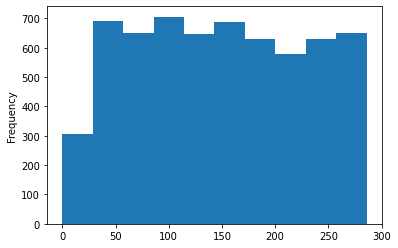

In [17]:
df_train[text_col].apply(lambda x: len(x)).plot.hist()

In [18]:
tr_stopwords = stopwords.words('turkish')
tr_stopwords.append("hic")
tr_stopwords.append("dm")
tr_stopwords.append("vs")
tr_stopwords.append("ya")

def remove_punct(tok):
  tok = re.sub(r'[^\w\s]', '', tok)
  return tok

def normalize(tok):
  if tok.isdigit():
    tok = "digit"
  return tok

def clean(tok):
  tok = remove_punct(tok)
  tok = normalize(tok)

  return tok

def exceptions(tok):
  if not tok.isdigit() and len(tok)==1:
    return False

  if not tok:
    return False

  if tok in tr_stopwords:
    return False

  if tok.startswith('#') or tok.startswith("@"):
    return False
  
  return True

In [19]:
naive_tok = lambda text: text.split(" ")
sm_tok = lambda text: [clean(tok) for tok in text.split(" ") if exceptions(tok)]

In [20]:
all = []
for ls in df_train[text_col].apply(sm_tok).values:
  all += ls

In [21]:
df_train[text_col] = df_train[text_col].apply(lambda x: " ".join(sm_tok(x)))
df_test[text_col] = df_test[text_col].apply(lambda x: " ".join(sm_tok(x)))
#df_valid[text_col] = df_valid[text_col].apply(lambda x: " ".join(sm_tok(x)))

In [22]:
stratify = [np.random.choice(ls) for ls in df_train[label_col].values]

In [23]:
mlb = MultiLabelBinarizer()

lbls = mlb.fit_transform(df_train[label_col].values)
n_labels = lbls.shape[1]

In [24]:
"""
def objective(trial):
    C = trial.suggest_float("C", 0.0, 15)

    pred_probs = []
    true_probs = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123).split(stratify, stratify)
    for fold, (tr_ix, vl_ix) in enumerate(skf):
        #print(f"Fold: {fold}")
        tr_df, vl_df = df_train.iloc[tr_ix], df_train.iloc[vl_ix]
        tr_y, vl_y = labels[tr_ix], labels[vl_ix]
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
            ("model", OneVsRestClassifier(LogisticRegression(C=C, max_iter=5000)))
        ])
        vl_pred_probs = pipe.fit(tr_df[text_col], tr_y).predict_proba(vl_df[text_col])
        pred_probs.append(vl_pred_probs)
        true_probs.append(vl_y)

    pred = np.vstack(pred_probs)
    true = np.vstack(true_probs)

    pred = (pred>0.15) * 1.0

    score = f1_score(true, pred, average="samples") * 0.2 + f1_score(true, pred, average="macro") * 0.8
    return score
"""


'\ndef objective(trial):\n    C = trial.suggest_float("C", 0.0, 15)\n\n    pred_probs = []\n    true_probs = []\n    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123).split(stratify, stratify)\n    for fold, (tr_ix, vl_ix) in enumerate(skf):\n        #print(f"Fold: {fold}")\n        tr_df, vl_df = df_train.iloc[tr_ix], df_train.iloc[vl_ix]\n        tr_y, vl_y = labels[tr_ix], labels[vl_ix]\n        pipe = Pipeline([\n            ("tfidf", TfidfVectorizer(ngram_range=(1,2))),\n            ("model", OneVsRestClassifier(LogisticRegression(C=C, max_iter=5000)))\n        ])\n        vl_pred_probs = pipe.fit(tr_df[text_col], tr_y).predict_proba(vl_df[text_col])\n        pred_probs.append(vl_pred_probs)\n        true_probs.append(vl_y)\n\n    pred = np.vstack(pred_probs)\n    true = np.vstack(true_probs)\n\n    pred = (pred>0.15) * 1.0\n\n    score = f1_score(true, pred, average="samples") * 0.2 + f1_score(true, pred, average="macro") * 0.8\n    return score\n'

In [25]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=10)

In [41]:
import numpy as np
import torch
import torch.nn as nn


class IntentDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, num_classes=n_labels):
        self.df = df
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text, label = row.text, self._encode_label(row[label_col])
        encoding = tokenizer(text, max_length=128, padding="max_length", truncation=True)
        encoding = {key: torch.tensor(val) for key, val in encoding.items()}
        encoding[label_col] = torch.tensor(label)
        return dict(encoding)
    
    def _encode_label(self, labels):
        encoded_labels = np.zeros(self.num_classes)
        for label in labels:
            encoded_labels[label] = 1.0
        return encoded_labels

device = torch.device('cuda:0')
#class_weights = order_category_weights(df, label_col="theme_V2", encoder=mlb)
class_weights = torch.Tensor([1.0] * 10)
class_weights[0] = 1
class_weights[1] = 1.5167249178108022
class_weights[2] = 1.7547338578655642
class_weights[3] = 1.9610520059358458
class_weights[4] = 1.269341370129623
class_weights[5] = 1.8684086209021484 + 0.3
class_weights[6] = 1.8019018017117145
class_weights[7] = 2.110648663094536
class_weights[8] = 3.081208739200435
class_weights[9] = 1.7994815143101963

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    weight = class_weights.to(device)
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.MultiLabelSoftMarginLoss(weight=weight)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [42]:
from transformers import AutoTokenizer

model_name = "loodos/bert-base-turkish-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/config.json
Model config BertConfig {
  "_name_or_path": "loodos/bert-base-turkish-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/vocab.txt
loading file tok

In [43]:
ds = IntentDataset(df_train)
ds[1]["labels"].shape

torch.Size([10])

In [44]:
pred_probs = []
true_probs = []
new_indices = []

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123).split(stratify, stratify)
for fold, (tr_ix, vl_ix) in enumerate(skf):
  tr_df, vl_df = df_train.iloc[tr_ix], df_train.iloc[vl_ix]
  tr_y, vl_y = lbls[tr_ix], lbls[vl_ix]
  
  training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to=None,
    num_train_epochs=4)
  

  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_labels, problem_type="multi_label_classification")

  trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=IntentDataset(tr_df),
      eval_dataset=IntentDataset(vl_df),
  )

  trainer.train()
  preds = trainer.predict(IntentDataset(vl_df))
  vl_pred_probs = preds.predictions

  pred_probs.append(vl_pred_probs)
  true_probs.append(vl_y)
  new_indices.append(np.array(vl_ix))

pred = np.vstack(pred_probs)
true = np.vstack(true_probs)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/config.json
Model config BertConfig {
  "_name_or_path": "loodos/bert-base-turkish-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "inte

Epoch,Training Loss,Validation Loss
1,No log,0.293812
2,No log,0.237345
3,No log,0.227515
4,0.255900,0.227649


***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-129
Configuration saved in ./output/checkpoint-129/config.json
Model weights saved in ./output/checkpoint-129/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-258
Configuration saved in ./output/checkpoint-258/config.json
Model weights saved in ./output/checkpoint-258/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-387
Configuration saved in ./output/checkpoint-387/config.json
Model weights saved in ./output/checkpoint-387/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-516
Configuration saved in ./output/checkpoint-516/config.json
Model weights saved in ./output/checkpoint-516/pytorch_model.bin


Training compl

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/config.json
Model config BertConfig {
  "_name_or_path": "loodos/bert-base-turkish-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "inte

Epoch,Training Loss,Validation Loss
1,No log,0.308394
2,No log,0.239731
3,No log,0.226812
4,0.260200,0.225744


***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-129
Configuration saved in ./output/checkpoint-129/config.json
Model weights saved in ./output/checkpoint-129/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-258
Configuration saved in ./output/checkpoint-258/config.json
Model weights saved in ./output/checkpoint-258/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-387
Configuration saved in ./output/checkpoint-387/config.json
Model weights saved in ./output/checkpoint-387/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2058
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-516
Configuration saved in ./output/checkpoint-516/config.json
Model weights saved in ./output/checkpoint-516/pytorch_model.bin


Training compl

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/config.json
Model config BertConfig {
  "_name_or_path": "loodos/bert-base-turkish-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "inte

Epoch,Training Loss,Validation Loss
1,No log,0.291780
2,No log,0.242576
3,No log,0.232623
4,0.250600,0.235191


***** Running Evaluation *****
  Num examples = 2057
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-129
Configuration saved in ./output/checkpoint-129/config.json
Model weights saved in ./output/checkpoint-129/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2057
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-258
Configuration saved in ./output/checkpoint-258/config.json
Model weights saved in ./output/checkpoint-258/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2057
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-387
Configuration saved in ./output/checkpoint-387/config.json
Model weights saved in ./output/checkpoint-387/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2057
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-516
Configuration saved in ./output/checkpoint-516/config.json
Model weights saved in ./output/checkpoint-516/pytorch_model.bin


Training compl

### OOF Valid Predictions

In [273]:
pred_sig = torch.sigmoid(torch.Tensor(pred)).numpy()
#pred_threshed = (pred_sig>0.25) * 1.0

In [292]:
alakasız = (pred_sig[:, 0] > 0.3) * 1
alakasız = alakasız.reshape(-1, 1)
lojistik = (pred_sig[:, 5] > 0.08) * 1
lojistik = lojistik.reshape(-1, 1)
yagma = (pred_sig[:, 8] > 0.5) * 1
yagma = yagma.reshape(-1, 1)

non_alakasız_1 = (pred_sig[:, 1:5] > 0.25) * 1
non_alakasız_2 = (pred_sig[:, 6:8] > 0.25) * 1
non_alakasız_3 = (pred_sig[:, 9:] > 0.25) * 1

pred_threshed = np.hstack([alakasız, non_alakasız_1, lojistik, non_alakasız_2, yagma, non_alakasız_3])

In [293]:
print(classification_report(true, pred_threshed))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2896
           1       0.73      0.86      0.79       830
           2       0.67      0.78      0.72       536
           3       0.67      0.80      0.73       384
           4       0.78      0.88      0.83      1416
           5       0.30      0.70      0.42       444
           6       0.72      0.79      0.75       495
           7       0.50      0.70      0.58       308
           8       0.67      0.66      0.66        99
           9       0.69      0.84      0.75       497

   micro avg       0.72      0.85      0.78      7905
   macro avg       0.66      0.79      0.71      7905
weighted avg       0.75      0.85      0.79      7905
 samples avg       0.80      0.87      0.81      7905



### Valid Predictions

In [47]:
#pred_valid = trainer.predict(IntentDataset(df_valid))

In [48]:
#pred_sig_valid = torch.sigmoid(torch.Tensor(pred_valid.predictions)).numpy()
#pred_threshed_test = (pred_sig_test>0.25) * 1.0

In [49]:
#alakasız = (pred_sig_valid[:, 0] > 0.25) * 1
#alakasız = alakasız.reshape(-1, 1)
#non_alakasız = (pred_sig_valid[:, 1:] > 0.25) * 1

#pred_threshed_valid = np.hstack([alakasız, non_alakasız])

In [50]:
#true_valid = mlb.transform(df_valid[label_col])

In [51]:
#print(classification_report(true_valid, pred_threshed_valid))

### Test Predictions

In [268]:
pred_test = trainer.predict(IntentDataset(df_test))

***** Running Prediction *****
  Num examples = 1544
  Batch size = 32


In [269]:
pred_sig_test = torch.sigmoid(torch.Tensor(pred_test.predictions)).numpy()
#pred_threshed_test = (pred_sig_test>0.25) * 1.0

In [270]:
alakasız = (pred_sig_test[:, 0] > 0.3) * 1
alakasız = alakasız.reshape(-1, 1)
lojistik = (pred_sig_test[:, 5] > 0.08) * 1
lojistik = lojistik.reshape(-1, 1)
yagma = (pred_sig_test[:, 8] > 0.5) * 1
yagma = yagma.reshape(-1, 1)

non_alakasız_1 = (pred_sig_test[:, 1:5] > 0.25) * 1
non_alakasız_2 = (pred_sig_test[:, 6:8] > 0.25) * 1
non_alakasız_3 = (pred_sig_test[:, 9:] > 0.25) * 1

pred_threshed_test = np.hstack([alakasız, non_alakasız_1, lojistik, non_alakasız_2, yagma, non_alakasız_3])

In [271]:
true_test = mlb.transform(df_test[label_col])

In [272]:
print(classification_report(true_test, pred_threshed_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       734
           1       0.80      0.86      0.83       207
           2       0.69      0.85      0.76       130
           3       0.66      0.78      0.72        94
           4       0.74      0.86      0.80       362
           5       0.35      0.79      0.49       112
           6       0.73      0.87      0.80       108
           7       0.54      0.78      0.64        78
           8       0.59      0.71      0.65        31
           9       0.69      0.85      0.76       117

   micro avg       0.72      0.86      0.79      1973
   macro avg       0.67      0.82      0.73      1973
weighted avg       0.75      0.86      0.80      1973
 samples avg       0.80      0.88      0.82      1973



### Full Training

In [240]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to=None,
    num_train_epochs=4)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_labels, problem_type="multi_label_classification")

final_trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=IntentDataset(df_train),
      eval_dataset=IntentDataset(df_train),
  )

final_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--loodos--bert-base-turkish-uncased/snapshots/7875a51367752147af6ac44b131992284a4543b3/config.json
Model config BertConfig {
  "_name_or_path": "loodos/bert-base-turkish-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "inte

Epoch,Training Loss,Validation Loss
1,No log,0.234781
2,No log,0.164287
3,0.271300,0.124604
4,0.271300,0.108617


***** Running Evaluation *****
  Num examples = 6173
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-193
Configuration saved in ./output/checkpoint-193/config.json
Model weights saved in ./output/checkpoint-193/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6173
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-386
Configuration saved in ./output/checkpoint-386/config.json
Model weights saved in ./output/checkpoint-386/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6173
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-579
Configuration saved in ./output/checkpoint-579/config.json
Model weights saved in ./output/checkpoint-579/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6173
  Batch size = 32
Saving model checkpoint to ./output/checkpoint-772
Configuration saved in ./output/checkpoint-772/config.json
Model weights saved in ./output/checkpoint-772/pytorch_model.bin


Training compl

TrainOutput(global_step=772, training_loss=0.22509371307847414, metrics={'train_runtime': 698.0297, 'train_samples_per_second': 35.374, 'train_steps_per_second': 1.106, 'total_flos': 1624301207918592.0, 'train_loss': 0.22509371307847414, 'epoch': 4.0})

In [294]:
pred_test = final_trainer.predict(IntentDataset(df_test))

***** Running Prediction *****
  Num examples = 1544
  Batch size = 32


In [295]:
pred_sig_test = torch.sigmoid(torch.Tensor(pred_test.predictions)).numpy()

In [296]:
alakasız = (pred_sig_test[:, 0] > 0.3) * 1
alakasız = alakasız.reshape(-1, 1)
lojistik = (pred_sig_test[:, 5] > 0.08) * 1
lojistik = lojistik.reshape(-1, 1)
yagma = (pred_sig_test[:, 8] > 0.5) * 1
yagma = yagma.reshape(-1, 1)

non_alakasız_1 = (pred_sig_test[:, 1:5] > 0.25) * 1
non_alakasız_2 = (pred_sig_test[:, 6:8] > 0.25) * 1
non_alakasız_3 = (pred_sig_test[:, 9:] > 0.25) * 1

pred_threshed_test = np.hstack([alakasız, non_alakasız_1, lojistik, non_alakasız_2, yagma, non_alakasız_3])

In [297]:
true_test = mlb.transform(df_test[label_col])

In [298]:
print(classification_report(true_test, pred_threshed_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       734
           1       0.81      0.86      0.84       207
           2       0.70      0.86      0.78       130
           3       0.74      0.76      0.75        94
           4       0.82      0.85      0.84       362
           5       0.36      0.77      0.49       112
           6       0.72      0.89      0.79       108
           7       0.57      0.76      0.65        78
           8       0.63      0.71      0.67        31
           9       0.74      0.87      0.80       117

   micro avg       0.75      0.86      0.80      1973
   macro avg       0.69      0.82      0.75      1973
weighted avg       0.77      0.86      0.81      1973
 samples avg       0.81      0.87      0.82      1973



In [322]:
name2ix = {'Alakasiz': 0, 'Barinma': 1, 'Elektronik': 2, 'Giysi': 3, 'Kurtarma': 4, 'Lojistik': 5, 'Saglik': 6, 'Su': 7, 'Yagma': 8, 'Yemek': 9}
ix2name = {}
for name, ix in name2ix.items():
  ix2name[ix] = name

In [323]:
df_test["pred"] = mlb.inverse_transform(pred_threshed_test)

df_test["annot"] = df_test.labels.apply(lambda ls: [ix2name[l] for l in ls])
df_test.pred = df_test.pred.apply(lambda ls: [ix2name[l] for l in ls])

In [324]:
df_test

,labels,text_cleaned,text,tweet_id,pred,annot
0,[1],abi acil adıyaman görev yapan eniştemden haber...,@yagosabuncuoglu Abi acil Adıyaman' da görev y...,e991c1cd57d453ecb3dc20b449abe2ae,[Barinma],[Barinma]
1,[5],maraştan uşağa gelecek bir depremzede aile var...,Maraş'tan Uşağa gelecek bir depremzede aile va...,331738e4a2ff527d812a5dc65f376460,[Barinma],[Lojistik]
2,[1],teyitli bilgi acil çadır ihtiyacı var iki küçü...,"""Teyitli bilgi: Acil çadır ihtiyacı var! İki k...",a7a67c0b79385129bdf16b19b88ef657,"[Barinma, Saglik]",[Barinma]
3,[0],paketleme insan gücüne ihtiyaç duyulan yer bil...,paketleme için insan gücüne ihtiyaç duyulan ye...,a20a8bbec7f156ba9d4d672e02e1df8b,[Lojistik],[Alakasiz]
4,[0],devlete ihanet içindesiniz yapmayın bir gün de...,Bu devlete çok ihanet içindesiniz yapmayın bi...,ce5419acd9d254c98c4ff8b05bdceeb6,[Alakasiz],[Alakasiz]
...,...,...,...,...,...,...
1539,[0],sen dıyorsun davar seni ihtiyaç 20kutu almak d...,@Bubbleblueme_ @SonSozMilletinn Sen ne dıyorsu...,863a1c11ed2d573faa65e73261c00aef,[Alakasiz],[Alakasiz]
1540,"[3, 9, 1, 4, 7]",merhabalar acil olarak paylaşır mısınızkahrama...,Merhabalar acil olarak paylaşır mısınız?Kahram...,349f165df40e55d39163204180a09925,"[Barinma, Giysi, Su, Yemek]","[Giysi, Yemek, Barinma, Kurtarma, Su]"
1541,[0],digit yıllık elektrikçilik tecrübem var ihtiya...,@ahbap 30 yıllık elektrikçilik tecrübem var ih...,858fe823a65550c7853e2fbec0939980,[Alakasiz],[Alakasiz]
1542,"[9, 3, 6, 7]",hayatda gıda ilaç giyecek ihtiyacı olanlara du...,"""HAYAT'DA GIDA, İLAÇ, GİYECEK İHTİYACI OLANLA...",76c3401c114055ad9e3e8a065d0788e8,"[Alakasiz, Saglik]","[Yemek, Giysi, Saglik, Su]"


### TO HUB

In [300]:
from huggingface_hub import HfApi, notebook_login

In [301]:
api = HfApi()
api.upload_folder(folder_path="/content/best_model_2023_02_13",
    path_in_repo="./",
    repo_id="deprem-ml/loodos_bert_base_uncased",
    repo_type="model",
    
    create_pr=1
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

'https://huggingface.co/deprem-ml/loodos_bert_base_uncased/tree/refs%2Fpr%2F1/./'

In [299]:
trainer.save_model("best_model_2023_02_13/best_model_2023_02_13")

Saving model checkpoint to best_model_2023_02_13/best_model_2023_02_13
Configuration saved in best_model_2023_02_13/best_model_2023_02_13/config.json
Model weights saved in best_model_2023_02_13/best_model_2023_02_13/pytorch_model.bin


### Clean Label Results on Train OOF

In [325]:
true_labels = [list(np.where(row==1)[0]) for i, row in enumerate(true)]

In [326]:
issues = find_label_issues(
    labels=true_labels,
    pred_probs=pred_sig,
    multi_label=True,
    return_indices_ranked_by="self_confidence",
)

In [327]:
len(issues)

1091

In [328]:
tweets = df_train.iloc[list(np.hstack(new_indices))][text_col].values

In [336]:
issues_df = pd.DataFrame({
"ix":list(np.hstack(new_indices)[issues]),
"comments":tweets[issues],
"true":np.array(mlb.inverse_transform(true))[list(issues)],
"pred":np.array(mlb.inverse_transform(pred_threshed))[list(issues)]})
issues_df.rename(columns={"true":"human_annot"}, inplace=True)

<ipython-input-336-01d47ee5a38c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "true":np.array(mlb.inverse_transform(true))[list(issues)],
<ipython-input-336-01d47ee5a38c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "pred":np.array(mlb.inverse_transform(pred_threshed))[list(issues)]})


In [338]:
issues_df.human_annot = issues_df.human_annot.apply(lambda ls: [ix2name[l] for l in ls])
issues_df.pred = issues_df.pred.apply(lambda ls: [ix2name[l] for l in ls])

In [339]:
issues_df

,ix,comments,human_annot,pred
0,529,hatay aknehir köyünde imkanlar kısıtlı acil bi...,"[Barinma, Giysi, Saglik, Su, Yemek]",[Alakasiz]
1,4180,merhaba teyitli ilk ağızdan gelen ihtiyaç tale...,"[Barinma, Giysi, Saglik, Su, Yemek]",[Alakasiz]
2,2243,köyler mağdur durumda kaldılar acil,"[Barinma, Giysi, Kurtarma, Su, Yemek]",[Alakasiz]
3,2639,acil yardım bekliyorlar,"[Barinma, Giysi, Su, Yemek]","[Alakasiz, Kurtarma]"
4,2146,buraya yardım gönderilmemiş lütfen acil bir şe...,"[Barinma, Giysi, Kurtarma, Saglik, Su, Yemek]",[Alakasiz]
...,...,...,...,...
1086,3480,gülhane tıp öğrencisi muhammet enes akgül şehi...,[Kurtarma],"[Elektronik, Kurtarma]"
1087,4371,projektör lazım odabaşı mahallesi digit no23 f...,[Kurtarma],"[Elektronik, Kurtarma, Lojistik]"
1088,3934,acil acil arkadaşlar malatya akçadağ bahri köy...,[Yemek],"[Su, Yemek]"
1089,3964,çadır ısıtıcı kırıkhanda bulunan insanların i...,[Barinma],"[Barinma, Elektronik]"


In [340]:
df_train.iloc[529]

labels                                            [3, 9, 1, 6, 7]
text_cleaned    hatay aknehir köyünde imkanlar kısıtlı acil bi...
text            Hatay Aknehir köyünde imkanlar çok kısıtlı Çok...
tweet_id                         004eb9ced1ec5ca2a71182dcf4363b1e
cl_scores                                                0.549545
human_annot                   [Giysi, Yemek, Barinma, Saglik, Su]
pred                             [Elektronik, Kurtarma, Lojistik]
Name: 529, dtype: object